In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,10)})

In [159]:
data = pd.read_excel('IMDb_database.xlsx')
data.head()

,Rank,Title,Year,Certificate,Runtime,Genre,Rating,Metascore,Votes,Gross,URL,Intro
0,1,The Dark Knight,2008,PG-13,152 min,"Action, Crime, Drama",9.0,84,2428474,534858444,https://imdb.com/title/tt0468569/,When the menace known as the Joker wreaks havo...
1,2,The Lord of the Rings: The Return of the King,2003,PG-13,201 min,"Action, Adventure, Drama",8.9,94,1715249,377845905,https://imdb.com/title/tt0167260/,Gandalf and Aragorn lead the World of Men agai...
2,3,Inception,2010,PG-13,148 min,"Action, Adventure, Sci-Fi",8.8,74,2179206,292576195,https://imdb.com/title/tt1375666/,A thief who steals corporate secrets through t...
3,4,The Lord of the Rings: The Fellowship of the Ring,2001,PG-13,178 min,"Action, Adventure, Drama",8.8,92,1736538,315544750,https://imdb.com/title/tt0120737/,A meek Hobbit from the Shire and eight compani...
4,5,The Mountain II,2016,,135 min,"Action, Drama, War",8.7,,106888,,https://imdb.com/title/tt5813916/,In a desolate war zone where screams of the in...


In [160]:
data.describe()

,Rank,Year,Rating,Votes
count,17483.000000,17483.000000,17483.000000,1.748300e+04
mean,757.889950,2002.676028,6.718286,1.358193e+05
std,665.311836,15.738938,0.954680,1.830410e+05
min,1.000000,1920.000000,1.000000,2.501600e+04
25%,233.000000,1997.000000,6.200000,4.090300e+04
50%,576.000000,2007.000000,6.800000,7.180000e+04
75%,1094.000000,2014.000000,7.400000,1.497080e+05
max,3015.000000,2021.000000,9.300000,2.474457e+06


In [161]:
m = data['Metascore'].unique()
m[4] == ' '

True

In [162]:
data['Metascore'] = data['Metascore'].replace(' ',np.nan)
data['Certificate'] = data['Certificate'].replace(' ',np.nan)
data['Gross'] = data['Gross'].replace(' ',np.nan)

In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17483 entries, 0 to 17482
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rank         17483 non-null  int64  
 1   Title        17483 non-null  object 
 2   Year         17483 non-null  int64  
 3   Certificate  17368 non-null  object 
 4   Runtime      17483 non-null  object 
 5   Genre        17483 non-null  object 
 6   Rating       17483 non-null  float64
 7   Metascore    7521 non-null   float64
 8   Votes        17483 non-null  int64  
 9   Gross        15234 non-null  float64
 10  URL          17483 non-null  object 
 11  Intro        17483 non-null  object 
dtypes: float64(3), int64(3), object(6)
memory usage: 1.6+ MB


In [164]:
data.corr(method='pearson')

,Rank,Year,Rating,Metascore,Votes,Gross
Rank,1.000000,0.195451,-0.544336,-0.277287,-0.265721,-0.142131
Year,0.195451,1.000000,-0.274793,-0.315174,0.051999,0.124838
Rating,-0.544336,-0.274793,1.000000,0.526936,0.360469,0.097617
Metascore,-0.277287,-0.315174,0.526936,1.000000,0.166493,0.017112
Votes,-0.265721,0.051999,0.360469,0.166493,1.000000,0.588034
Gross,-0.142131,0.124838,0.097617,0.017112,0.588034,1.000000


array([[<AxesSubplot:title={'center':'Rank'}>,
        <AxesSubplot:title={'center':'Year'}>],
       [<AxesSubplot:title={'center':'Rating'}>,
        <AxesSubplot:title={'center':'Metascore'}>],
       [<AxesSubplot:title={'center':'Votes'}>,
        <AxesSubplot:title={'center':'Gross'}>]], dtype=object)

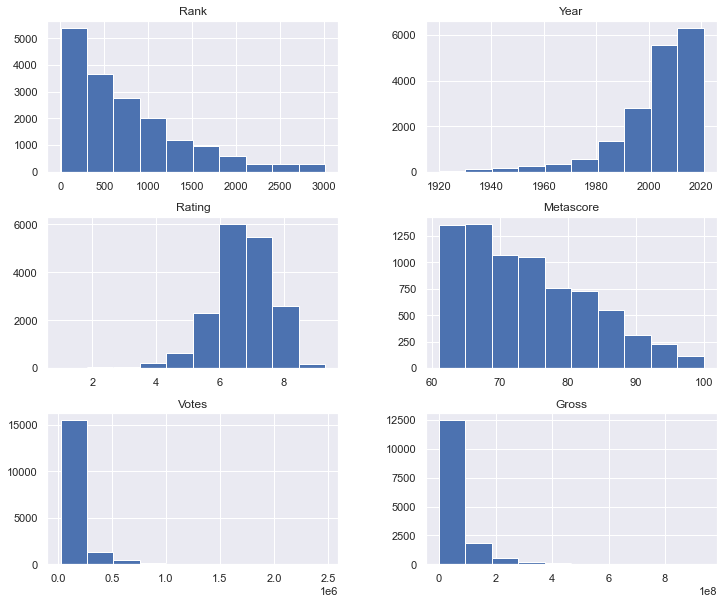

In [165]:
data.hist()

In [166]:
# get the movie_time_min from Runtime with apply mehtod
x = lambda x: int(x.split(' ')[0])
data['Movie_time_min'] = data['Runtime'].apply(x)
data.head(1)

,Rank,Title,Year,Certificate,Runtime,Genre,Rating,Metascore,Votes,Gross,URL,Intro,Movie_time_min
0,1,The Dark Knight,2008,PG-13,152 min,"Action, Crime, Drama",9.0,84.0,2428474,534858444.0,https://imdb.com/title/tt0468569/,When the menace known as the Joker wreaks havo...,152


In [167]:
# get the all genres
g = data['Genre'].unique()
l = []
for i in range(len(g)):
    tmp = g[i].split(',')
    for j in tmp:
        if j not in l:
            l.append(j)
l = [x.strip() for x in l]
l = set(l)
len(l)

21

In [168]:
# add column for each genre
tmp = [x.replace(' ','').split(',') for x in data['Genre'].tolist()]
for i in l:
    data[i] = 0

for i in range(13,34):
    for j in range(len(tmp)):
        if data.columns[i] in tmp[j]:
            data.iloc[j,i] = 1
        else:
            data.iloc[j,i] = 0
data.sample(5)

,Rank,Title,Year,Certificate,Runtime,Genre,Rating,Metascore,Votes,Gross,...,Thriller,Adventure,Drama,Mystery,Action,Comedy,Animation,Romance,Fantasy,Western
7211,578,Key Largo,1948,Not Rated,100 min,"Action, Crime, Drama",7.8,NaN,39123,NaN,...,0,0,1,0,1,0,0,0,0,0
13283,228,Fruitvale Station,2013,R,85 min,"Biography, Crime, Drama",7.5,85.0,78829,16097842.0,...,0,0,1,0,0,0,0,0,0,0
13141,86,Whisper of the Heart,1995,G,111 min,"Animation, Drama, Family",7.9,75.0,57264,NaN,...,0,0,1,0,0,0,1,0,0,0
15484,267,Dead Man's Shoes,2004,Not Rated,90 min,"Crime, Drama, Thriller",7.6,NaN,51780,6013.0,...,1,0,1,0,0,0,0,0,0,0
651,652,Seraphim Falls,2006,R,115 min,"Action, Drama, Thriller",6.7,62.0,30919,418296.0,...,1,0,1,0,1,0,0,0,0,0


In [169]:
data.describe()

,Rank,Year,Rating,Metascore,Votes,Gross,Movie_time_min,Sport,War,Sci-Fi,...,Thriller,Adventure,Drama,Mystery,Action,Comedy,Animation,Romance,Fantasy,Western
count,17483.000000,17483.000000,17483.000000,7521.000000,1.748300e+04,1.523400e+04,17483.000000,17483.000000,17483.000000,17483.000000,...,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000,17483.000000
mean,757.889950,2002.676028,6.718286,73.967558,1.358193e+05,5.749955e+07,111.065035,0.018532,0.014929,0.093176,...,0.151118,0.280844,0.520906,0.117943,0.340102,0.362695,0.094091,0.133844,0.103987,0.006807
std,665.311836,15.738938,0.954680,9.465180,1.830410e+05,7.897623e+07,21.059282,0.134870,0.121271,0.290688,...,0.358174,0.449424,0.499577,0.322550,0.473757,0.480792,0.291964,0.340495,0.305252,0.082223
min,1.000000,1920.000000,1.000000,61.000000,2.501600e+04,4.410000e+02,45.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,233.000000,1997.000000,6.200000,66.000000,4.090300e+04,8.586380e+06,97.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,576.000000,2007.000000,6.800000,72.000000,7.180000e+04,3.259893e+07,107.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1094.000000,2014.000000,7.400000,81.000000,1.497080e+05,7.158392e+07,121.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,3015.000000,2021.000000,9.300000,100.000000,2.474457e+06,9.366622e+08,321.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'PG-13'),
  Text(1, 0, 'R'),
  Text(2, 0, 'PG'),
  Text(3, 0, 'Not Rated'),
  Text(4, 0, 'Passed'),
  Text(5, 0, 'TV-MA'),
  Text(6, 0, 'TV-14'),
  Text(7, 0, 'G'),
  Text(8, 0, 'Approved'),
  Text(9, 0, 'M'),
  Text(10, 0, 'TV-PG'),
  Text(11, 0, 'M/PG'),
  Text(12, 0, 'GP'),
  Text(13, 0, 'Unrated'),
  Text(14, 0, 'NC-17'),
  Text(15, 0, 'TV-G'),
  Text(16, 0, 'X')])

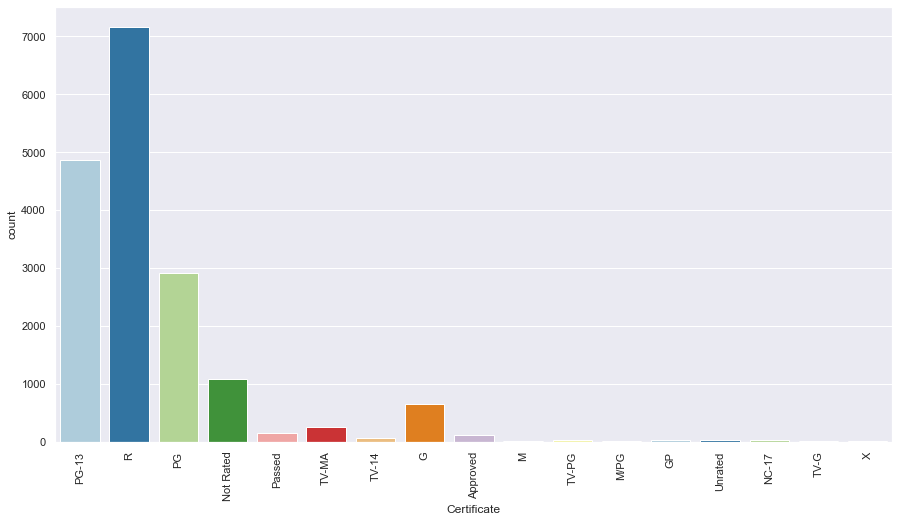

In [170]:
# countplot for certificate
plt.figure(figsize = (15,8))
sns.color_palette("magma", as_cmap=True)
ax = sns.countplot(x='Certificate', data= data, palette='Paired')
plt.xticks(rotation= 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77]),
 [Text(0, 0, '1.0'),
  Text(1, 0, '1.1'),
  Text(2, 0, '1.2'),
  Text(3, 0, '1.4'),
  Text(4, 0, '1.8'),
  Text(5, 0, '1.9'),
  Text(6, 0, '2.0'),
  Text(7, 0, '2.1'),
  Text(8, 0, '2.2'),
  Text(9, 0, '2.4'),
  Text(10, 0, '2.5'),
  Text(11, 0, '2.7'),
  Text(12, 0, '2.8'),
  Text(13, 0, '2.9'),
  Text(14, 0, '3.0'),
  Text(15, 0, '3.1'),
  Text(16, 0, '3.2'),
  Text(17, 0, '3.3'),
  Text(18, 0, '3.4'),
  Text(19, 0, '3.5'),
  Text(20, 0, '3.6'),
  Text(21, 0, '3.7'),
  Text(22, 0, '3.8'),
  Text(23, 0, '3.9'),
  Text(24, 0, '4.0'),
  Text(25, 0, '4.1'),
  Text(26, 0, '4.2'),
  Text(27, 0, '4.3'),
  Text(28, 0, '4.4'),
  Text(29, 0, '4.5

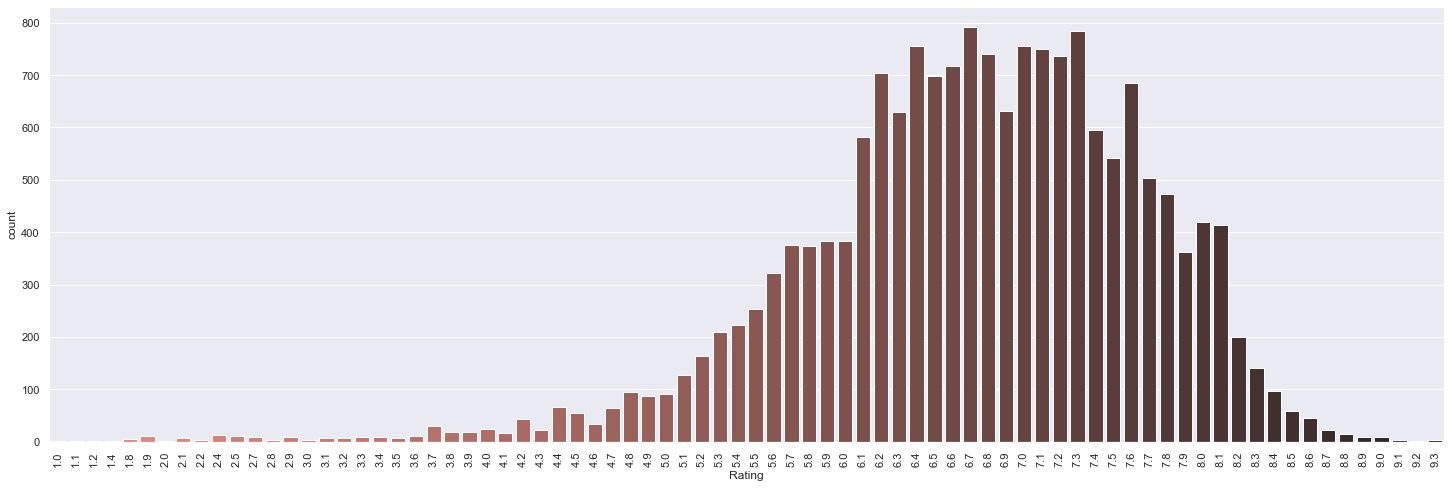

In [171]:
# countplot rating
plt.figure(figsize = (25,8))
ax = sns.countplot(x='Rating', data= data, palette='dark:salmon_r')
plt.xticks(rotation= 90)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151]),
 [Text(0, 0, '45'),
  Text(1, 0, '46'),
  Text(2, 0, '63'),
  Text(3, 0, '64'),
  Text(4, 0, '66'),
  Text(5, 0, '67'),
  Text(6, 0, '68'),
  

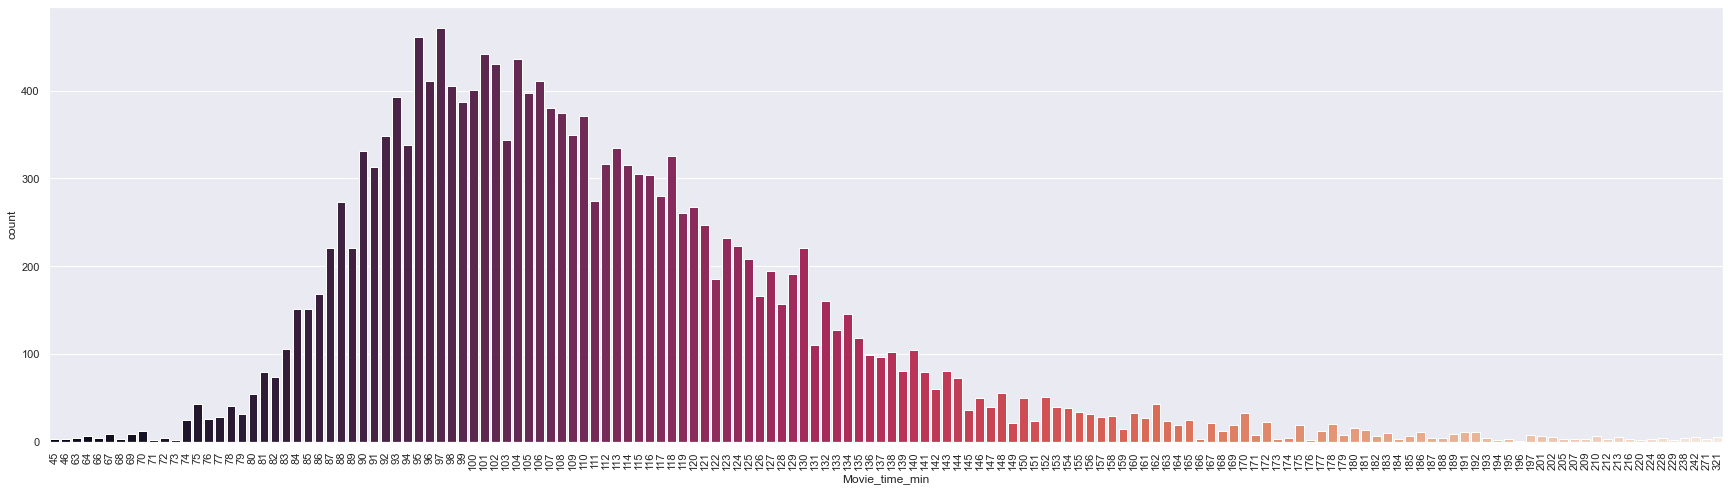

In [172]:
# countplot for Runtime
plt.figure(figsize = (30,8))
sns.color_palette("magma", as_cmap=True)
ax = sns.countplot(x='Movie_time_min', data= data, palette='rocket')
plt.xticks(rotation= 90)

(array([1900., 1920., 1940., 1960., 1980., 2000., 2020., 2040.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

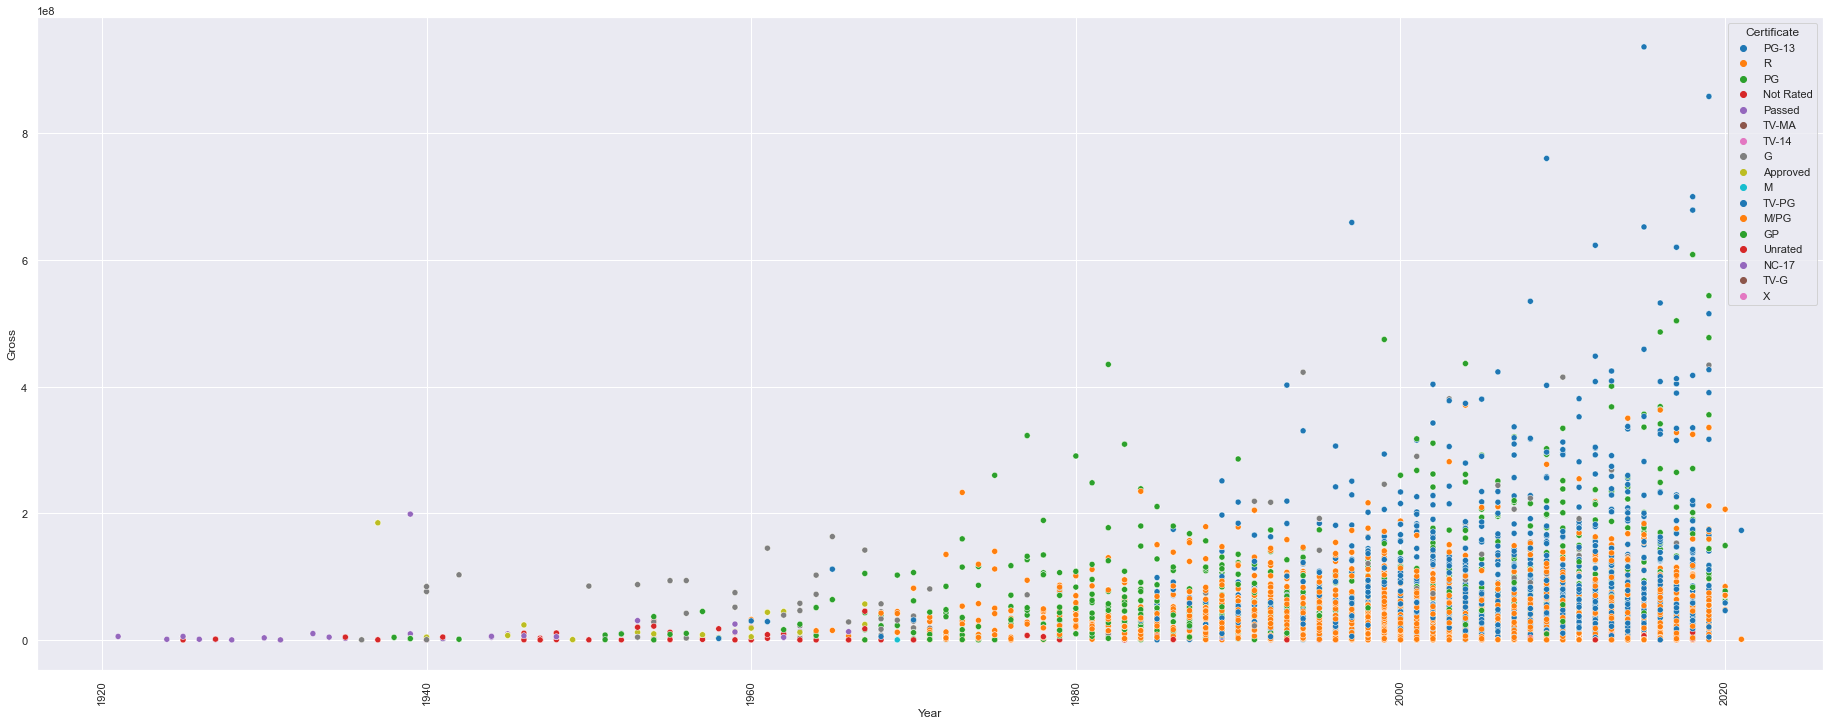

In [173]:

plt.figure(figsize = (32,12))
ax = sns.scatterplot(x='Year', y='Gross', data= data,hue='Certificate', palette='tab10')
plt.xticks(rotation= 90)

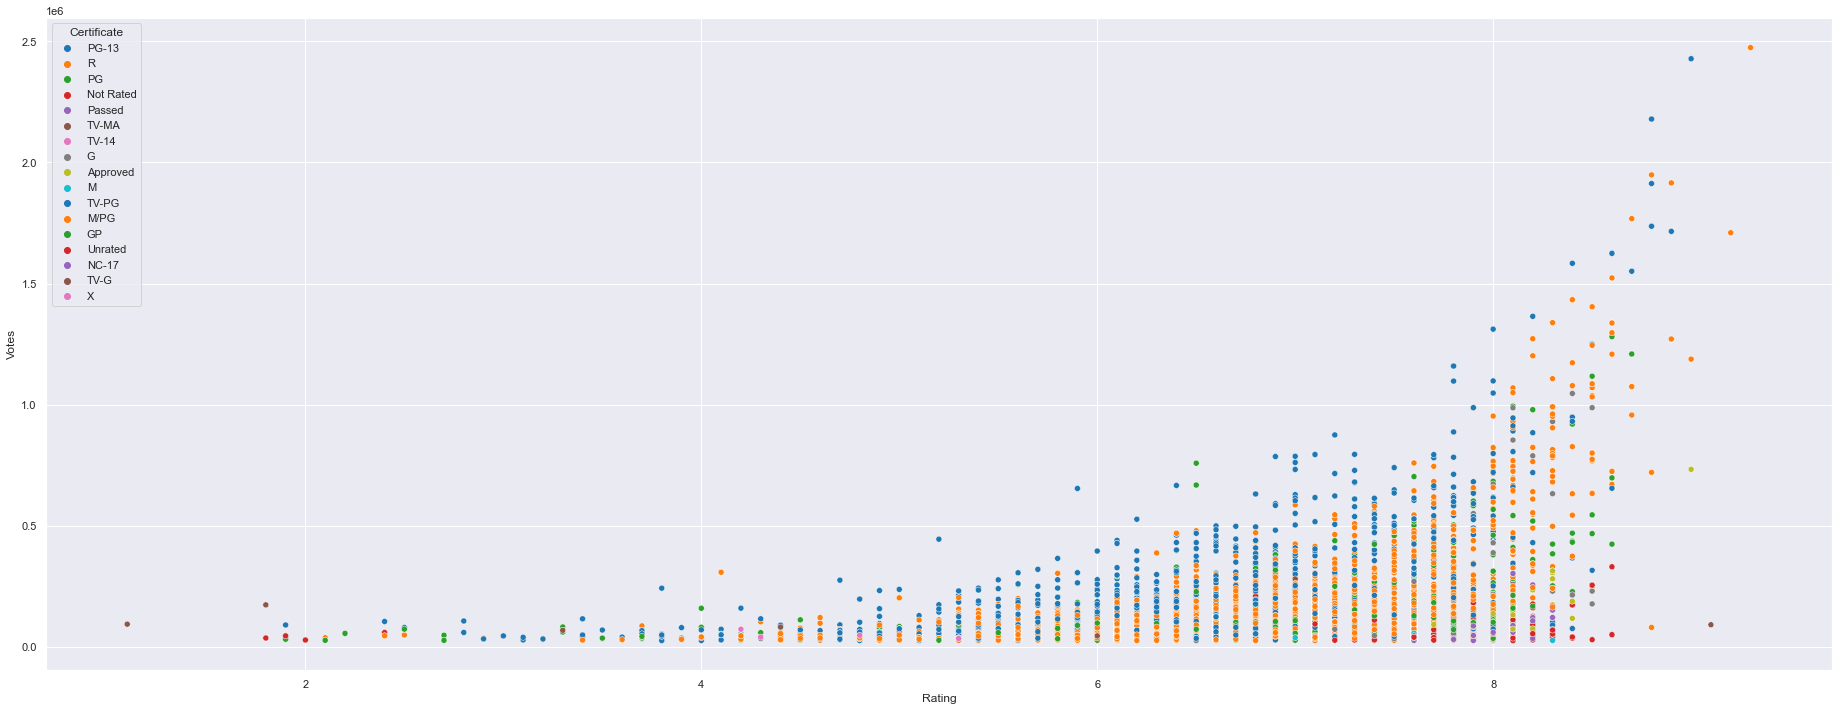

In [174]:
plt.figure(figsize = (32,12))
ax = sns.scatterplot(x='Rating', y='Votes', data= data,hue='Certificate', palette='tab10')

<AxesSubplot:title={'center':'Mean Rating Per Year'}, xlabel='Year'>

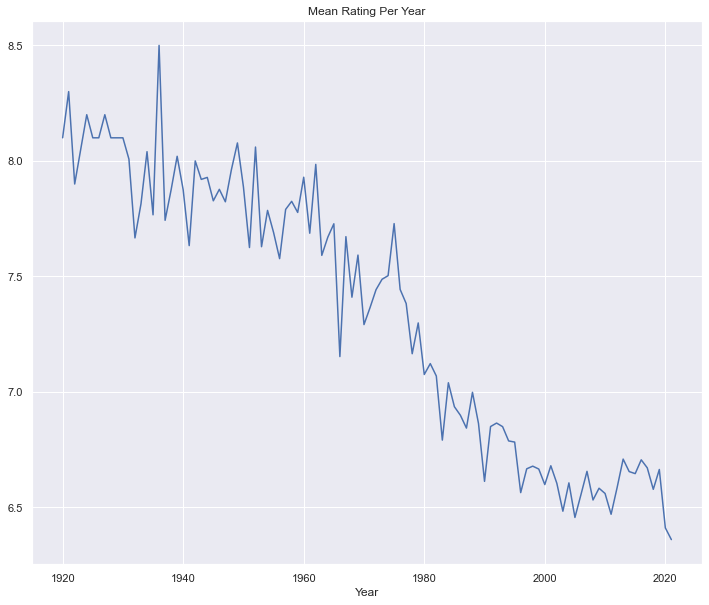

In [175]:
# mean rating for each year
mean_rating_year = data.groupby(by=['Year'])['Rating'].mean()
mean_rating_year.plot(title='Mean Rating Per Year')

<AxesSubplot:title={'center':'Mean Movie Time Per Year'}, xlabel='Year'>

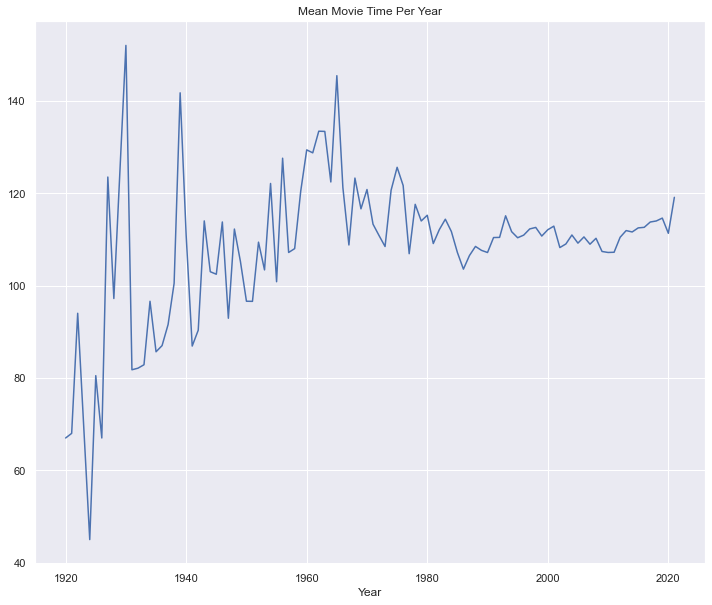

In [176]:
mean_time_year = data.groupby(by=['Year'])['Movie_time_min'].mean()
mean_time_year.plot(kind='line',title='Mean Movie Time Per Year')

In [177]:
genre_description = data[l].describe().T
genre_description.sort_values(by='mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
Drama,17483.0,0.520906,0.499577,0.0,0.0,1.0,1.0,1.0
Comedy,17483.0,0.362695,0.480792,0.0,0.0,0.0,1.0,1.0
Action,17483.0,0.340102,0.473757,0.0,0.0,0.0,1.0,1.0
Adventure,17483.0,0.280844,0.449424,0.0,0.0,0.0,1.0,1.0
Crime,17483.0,0.234170,0.423491,0.0,0.0,0.0,0.0,1.0
Thriller,17483.0,0.151118,0.358174,0.0,0.0,0.0,0.0,1.0
Romance,17483.0,0.133844,0.340495,0.0,0.0,0.0,0.0,1.0
Mystery,17483.0,0.117943,0.322550,0.0,0.0,0.0,0.0,1.0
Horror,17483.0,0.112624,0.316141,0.0,0.0,0.0,0.0,1.0
Fantasy,17483.0,0.103987,0.305252,0.0,0.0,0.0,0.0,1.0


In [181]:
# select the most 6 genres
drama = data[data['Drama'] == 1]
comedy = data[data['Comedy'] == 1]
action = data[data['Action'] == 1]
adventure = data[data['Adventure'] == 1]
crime = data[data['Crime'] == 1]
thriller = data[data['Thriller'] == 1]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

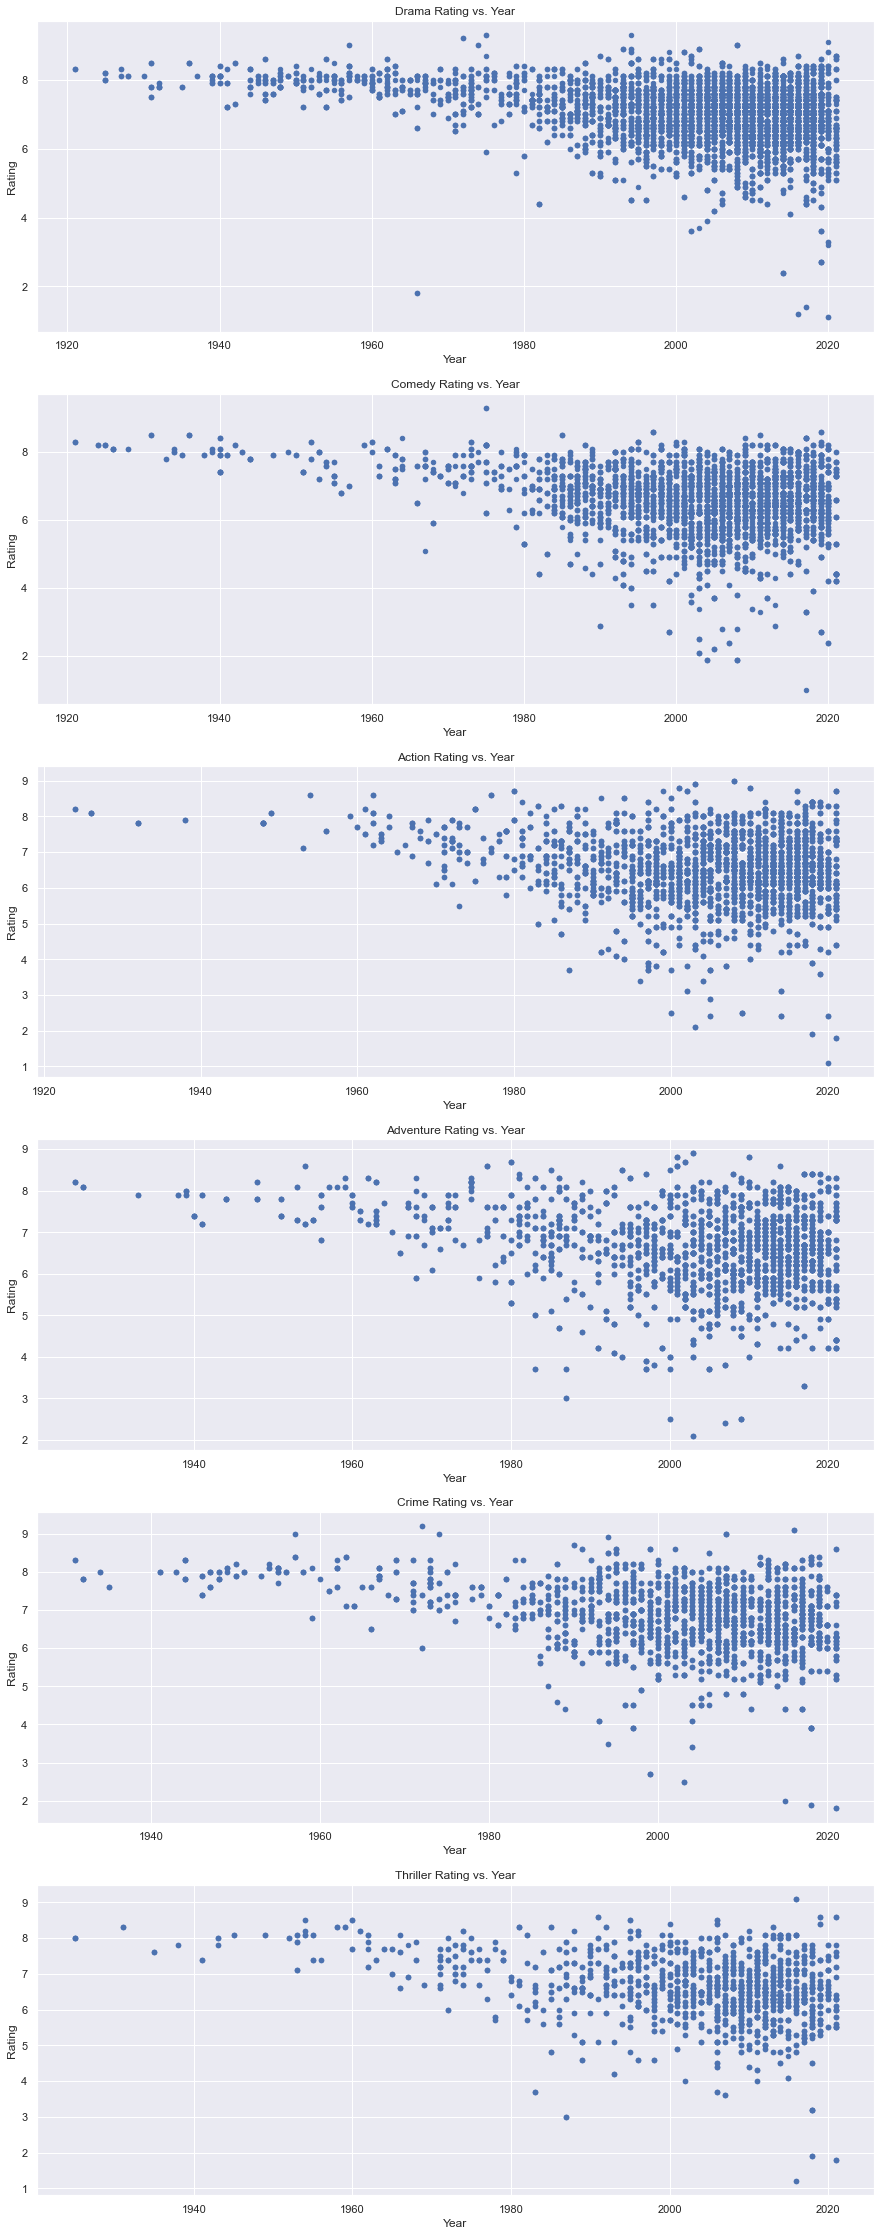

In [207]:
top_6 = [drama,comedy,action,adventure,crime,thriller]

figure, axes = plt.subplots(6, 1, figsize=(15,40))

title = ' Rating vs. Year'
pre = ['Drama', 'Comedy', 'Action', 'Adventure', 'Crime', 'Thriller']
Title = [x + title for x in pre]

for i in range(len(top_6)):
    top_6[i].plot(kind='scatter',x='Year',y='Rating',ax=axes[i],title=Title[i])



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

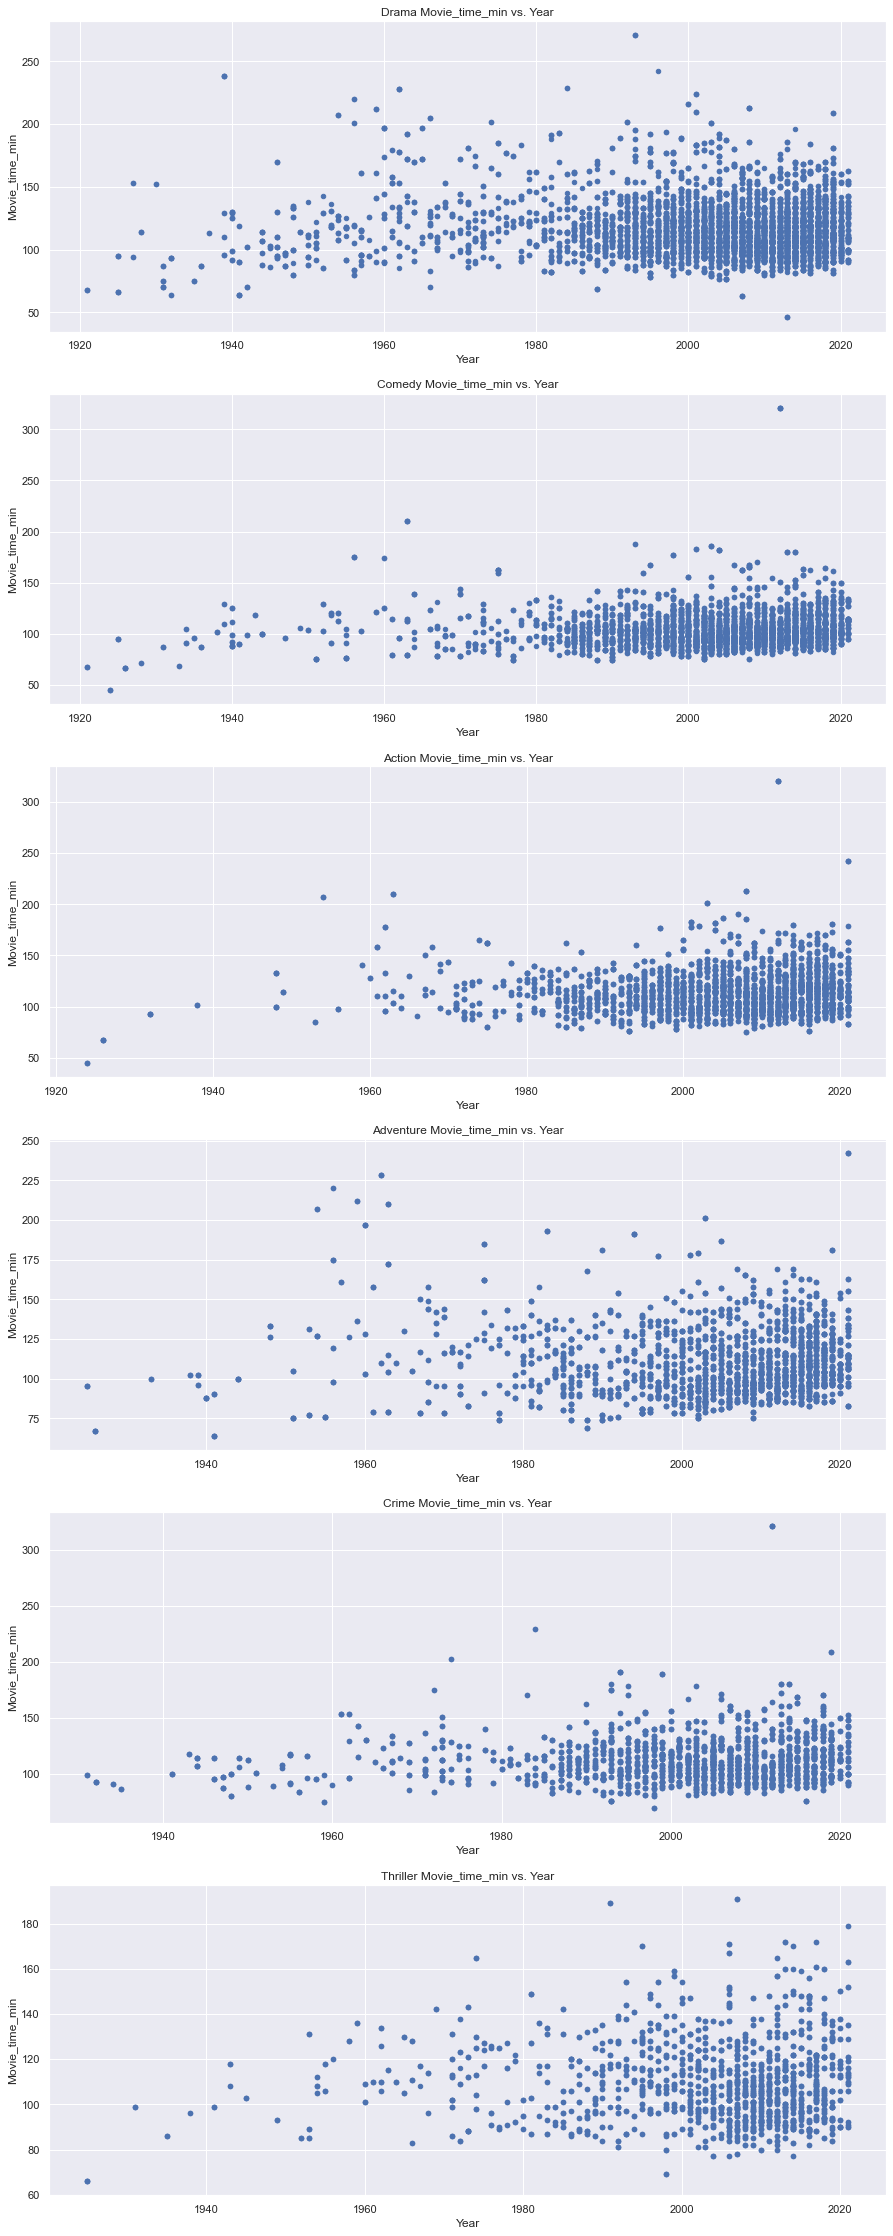

In [210]:
figure, axes = plt.subplots(6, 1, figsize=(15,40))

title = ' Movie_time_min vs. Year'
pre = ['Drama', 'Comedy', 'Action', 'Adventure', 'Crime', 'Thriller']
Title = [x + title for x in pre]

for i in range(len(top_6)):
    top_6[i].plot(kind='scatter',x='Year',y='Movie_time_min',ax=axes[i],title=Title[i])

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

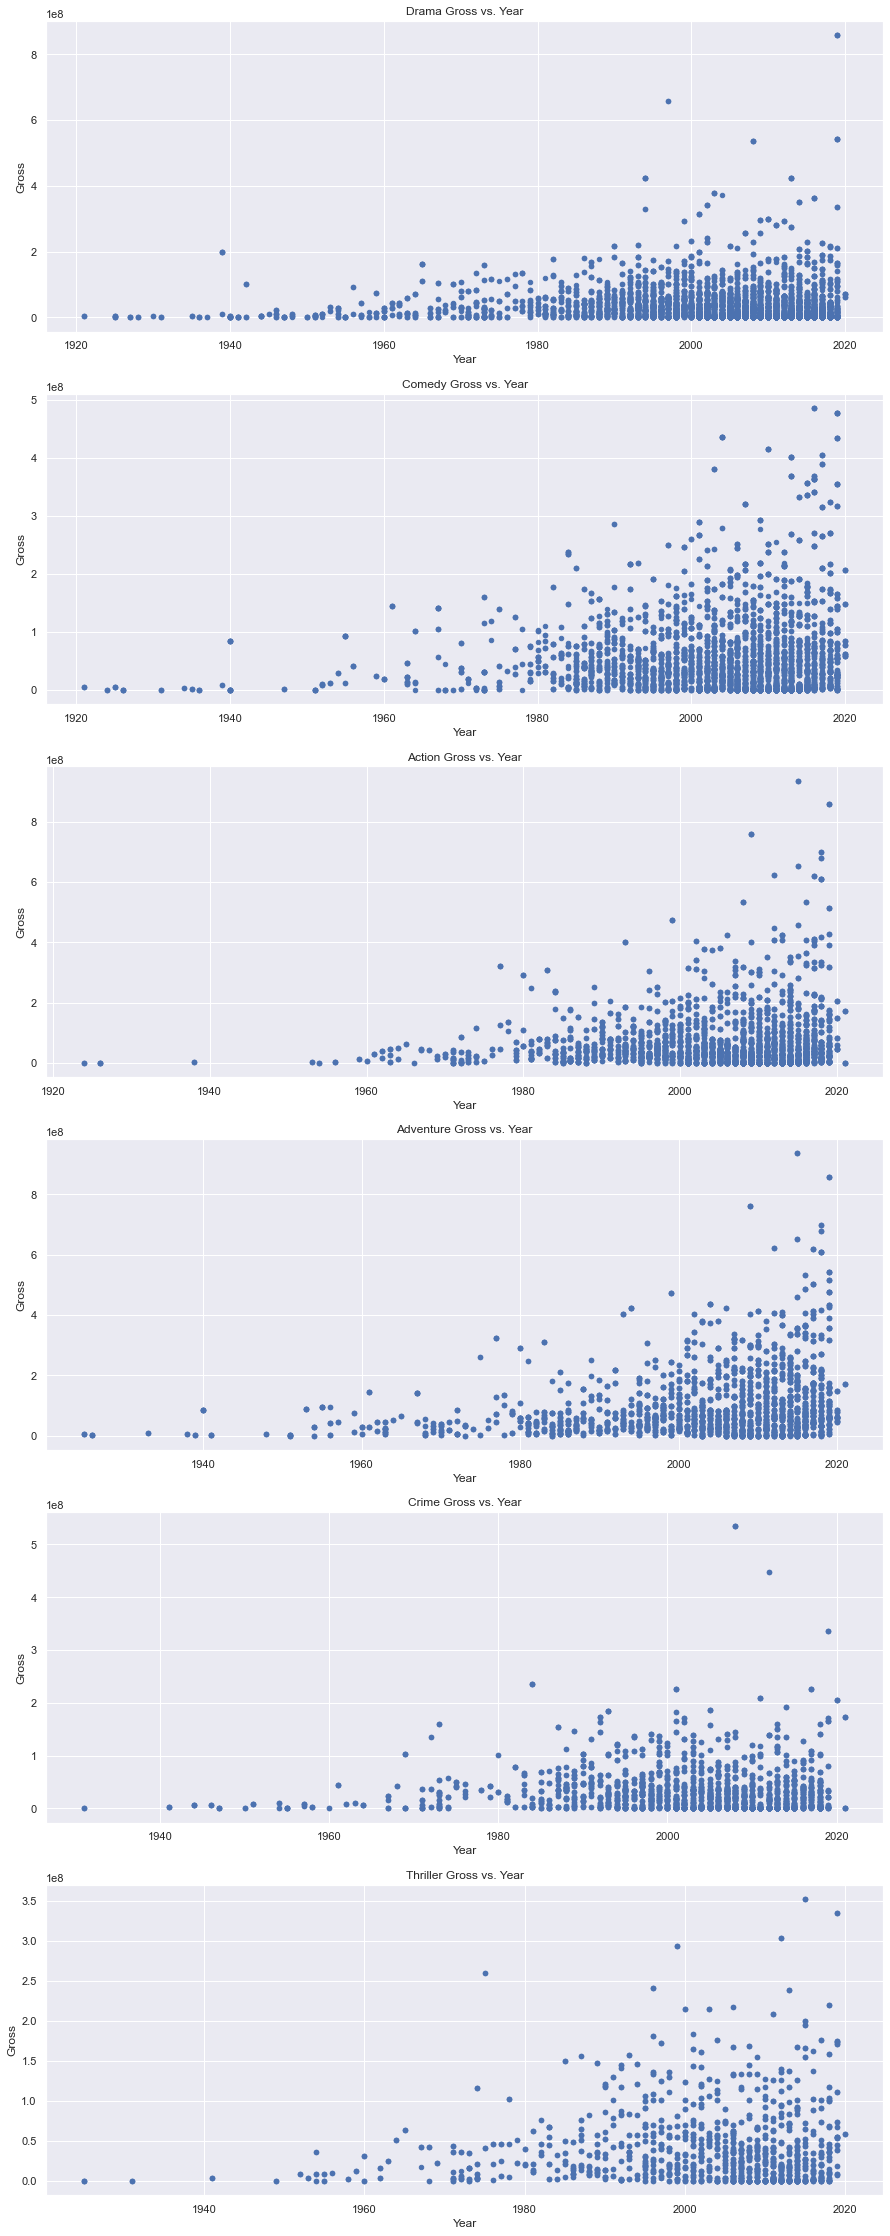

In [211]:
figure, axes = plt.subplots(6, 1, figsize=(15,40))

title = ' Gross vs. Year'
pre = ['Drama', 'Comedy', 'Action', 'Adventure', 'Crime', 'Thriller']
Title = [x + title for x in pre]

for i in range(len(top_6)):
    top_6[i].plot(kind='scatter',x='Year',y='Gross',ax=axes[i],title=Title[i])

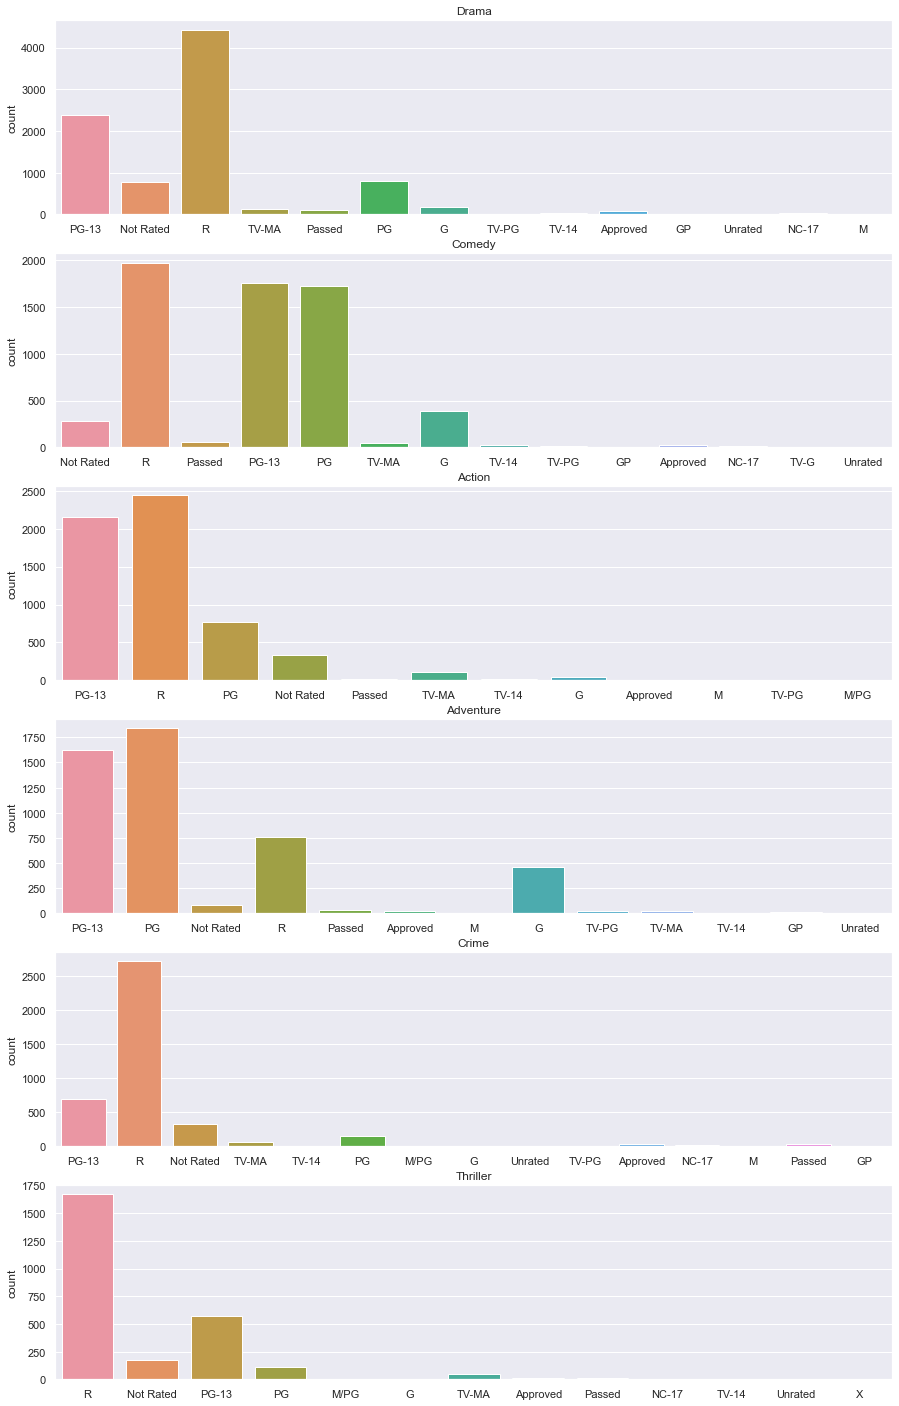

In [231]:
figure, axes = plt.subplots(6, 1, figsize=(15,25))

title = ' Certificate'
pre = ['Drama', 'Comedy', 'Action', 'Adventure', 'Crime', 'Thriller']
Title = [x + title for x in pre]

for i in range(len(top_6)):
    ax = sns.countplot(x='Certificate',data=top_6[i], ax = axes[i])
    ax.set(title=pre[i],xlabel='')